## 1. Dispatch Optimisation Problem - Theoretical description
1. Define/Create model
    * Abstract or Concrete
2. Populate parameters
3. Decision variables
4. Objective function
5. Constraints
6. Implementation

### Formulation of the (economic) Dispatch problem
* Packages used:
    * Pyomo
    * ...

#### 1. Parameters
* PV-specific:
    * *None*
* BESS-specific:
    * Max Storage Capacity
    * Charging Capacity == Discharge Capacity
    * Charge-Efficiency
    * Discharge-Efficiency
    * *Roundtrip Efficiency
    * Mac SoC
    * Min SoC
* Other system-specific parameters:
    * Inverter efficiency
    * PV-BESS system cost
    * Max Grid Volume
* Other parameters that the dispatcher requires:
    * Profit {calculated from the power flows and electricity price at each time-step *t*}
    * State-of-Charge [SoC] {traced/calculated from the SoC[*t-1*] and power flows to/from BESS}

#### 2. Decision Variables
*Decision variables in the dispatch model are not the same as in the global optimisation problem. In the dispatch problem, the decision variables are the different power flows at each time-step *t*
* PV_to_Load
* PV_to_BESS
* PV_curtailment
* PV_to_Grid
* BESS_to_Load
* BESS_to_Grid
* Grid_to_Load
* Grid_to_BESS

#### 3. Objective Function
* MinimiseCost = 
    $$
    min( 
        \sum_{t=o}^{8760} (
            C_{grid}^i[t] * P_{Grid-to-Load}[t]                                                     %cost of electricity from grid
            + C_{PV+BESS}^i[t] * [P_{PV-to-Load}[t] + P_{BESS-to-Load}[t]]                          %cost of electricity from PV-BESS system
            + C_{penalty}^{Curtailment} * P_{Curtailment}[t]                                        %penalty for curtailing PV production
            - C_{grid}^i[t] * [[P_{BESS-to-Grid}[t] + P_{PV-to-Grid}[t] ] - P_{Grid-to-BESS}[t]]    %profit from energy arbitrage
        )
    )
    $$

#### 4. Constraints
* Load fulfilment
    $$
        P_{Load}[t] = P_{PV-to-Load}[t] + P_{BESS-to-Load}[t] + P_{Grid}[t]
    $$
* Solar production
    $$
        P_{PV production}[t] = \frac{P_{PV-to-Load}[t] + P_{PV-to-BESS}[t] + P_{PV-to-Grid}[t]}{\xi_{inverter}} + P_{Curtailment}[t]
    $$
* SoC range
    $$
        SoC^{min} < SoC[t] < SoC^{max} ; \qquad \forall \ \ t
    $$
* SoC tracking
    $$
        SoC[t] = (
            SoC[t-1]
            + ( P_{PV-to-BESS}[t] + P_{Grid-to-BESS}[t] * \xi_{charge} ) * \Delta{t}
            - \frac{P_{BESS-to-Load}[t] + P_{BESS-to-Grid}[t]}{\xi_{discharge}} * \Delta{t}
        )
    $$
##### 4.1 *Additional* Constraints
* Limiting power flows BESS-to-Grid and PV-to-Grid in energy arbitrage
    $$
        P_{PV-to-Grid}[t] + P_{BESS-to-Grid}[t] <= PowerFlowLimit
    $$
* Limiting the BESS charging to either charge or discharge in the same hour
    $$
        \forall \quad t; \qquad (P_{PV-to-BESS}[t], P_{Grid-to-BESS}[t])*ChargingState\ \ AND\ \ (P_{BESS-to-Load}[t], P_{BESS-to-Grid}[t])*(1-ChargingState)
    $$
    * Subject to:
    * SoC tracking
    $$
        SoC[t] = (
            SoC[t-1]
            + ( P_{PV-to-BESS}[t] + P_{Grid-to-BESS}[t] * \xi_{charge} * ChargingState) * \Delta{t}
            - \frac{P_{BESS-to-Load}[t] + P_{BESS-to-Grid}[t]}{\xi_{discharge}} * (1-ChargingState) * \Delta{t}
        )
    $$
___
___

The problem will be defined as a worker/tasks set, where the power flows are different "workers" and hours in day are differet "tasks"
The values in each cell has to be the cost, so I will eventually have to make some sort of a generator to populate it quickly

| Flow \ Hour |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 | 10 | ... | 48 | H
|:---------------:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:
| P_PV-to-BESS      | $$p_{f, h}$$ |  $$p_{f, h}$$ |  $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | ... | - |
| P_PV-to-Load      | $$p_{f, h}$$ |  $$p_{f, h}$$ |  $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | ... | - |
| P_BESS-to-Load    | $$p_{f, h}$$ |  $$p_{f, h}$$ |  $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | $$p_{f, h}$$ | ... | - |
| ...               | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | - |
| P_n               | - |  - |  - |  - | - |  - | - | - | - | - | - | - |
**F**

Subject to:
$$
minimize[
    \quad
    \sum_{h=1}^{H}\ (
        \quad
        \sum_{f=1}^{F}\ (\ P_{f, h}\  *\  Cost_{f, h}\ )
        \quad
    )
    \
]
$$

## 2. Implementation

### Implementation notes

* General approach (for now) is to use the *ConcreteModel*
    * If *AbstractModel*, how could the model parameters,variables,etc be populated from the datafile OR the inputs of the model
    * *Why?* --> In the future, the model could be adapted to be compiled and to describe different kinds of and setups of energy systems with different technologies
* Be mindful of how the data is loaded and called in the model to avoid integration errors (like the previous error with numpy)
* Convert the model to kW (previously MW) to avoid issues/error with integer to float conversion
* **OBS!** Since the objective function will be sefined as a double summation function with a general element * factor statement, we need to prepare the cost matrix in a way that reflects energy arbitrage business case. Hence, the "cost" of selling energy to the grid is negative.
* *OBS!*: SoC[*t*] needs a previous value, so we need to artificially override the initial SoC (or implement an SoC for *t* = -1)
* In future implementations/improvements, try converting the time-step to seconds/minutes.
    * *Reason* is to have a more realistic dispatch profile where BESS can charge and discharge in the same hour
* To keep in mind for validation
    * I could also run it with different curtailment penalties and see their effect
    * Underlying difference in optimisation problem when optimising only each time-step vs. optimising a time series window

### Dispatch model

##### Importing packages

In [ ]:
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po
import time

In [ ]:
## To run the dispatcher later for multiple cases
## (Reference) Cases to run the dispatcher for after valdiation:
# power_PV=       [0.01, 0.03, 0.05, 0.1, 0.2]
# power_BESS=     [1, 3, 5, 10, 20]
# time_BESS=      [0, 1, 2, 3, 4]
# optimise_for=   ['Price', 'CO_2_eq']
power_PV=       [0.01, 0.03, 0.1]
power_BESS=     [1, 3, 10]
time_BESS=      [0, 2, 4]
optimise_for=   ['price', 'co2']

# Create a new list using list comprehension
referenceCases = []
for i in range(len(power_PV)):
    for j in range(len(power_BESS)):
        for k in range(len(time_BESS)):
            for curve in optimise_for:
                referenceCases.append([power_PV[i], power_BESS[j], power_BESS[j] * time_BESS[k], curve])

#referenceCases

##### Call in the data, specify the frames of the problem (flows, hours)

In [ ]:
price = pd.read_csv('Data/PriceCurve_SE3_2021.csv', sep = ';')
co2_pro = pd.read_csv('Data/production_emissions.csv')
co2_con = pd.read_csv('Data/consumption_emissions.csv')
pv = pd.read_csv('Data/pv_sam.csv')
load = pd.read_csv('Data/LoadCurve.csv', sep = ';')

data = load
data['Price'] = price['Grid_Price']
data['CO_2_eq'] = co2_pro['carbon_intensity_production_avg']
data['solar_PV'] = pv

#Converting from MW to kW
data['Load']= (data['Load'] * 1000)
#solar data is already in kW, but needs to be multiplied by the scaling factor
data['solar_PV']= (data['solar_PV'])
data['Price']= (data['Price'] / 1000)
data['CO_2_eq']= (data['CO_2_eq'] / 1000)

data['Hour']= (data['Hour']).astype('int')

#data.head(48)
#data.head(10)

In [ ]:
duplicated_rows = pd.concat([data.iloc[[-1]]] * 49, ignore_index=True)
#duplicated_rows

data = pd.concat([data, duplicated_rows], ignore_index=True)
#data

In [ ]:
#data.describe()

In [ ]:
## Primary data parameters of our scenarios
pv_price= 80                #https://data.nrel.gov/submissions/53 in EUR/kW
bess_price= 200             #https://doi.org/10.1016/j.solener.2018.08.061 in EUR/kWh, adjusted for price decreases
# pv_opex= 17                 #EUR/kWh ->reference in excel
# bess_opex= 0.125            #EUR/kWh ->reference in excel
pv_opex= 3
bess_opex= 6

pv_co2= 33                  #kgCO2eq/kW_powerDC ->reference in excel
bess_co2= 100               #kgCO2eq/kWh_capacity ->reference in excel
pv_opex_co2= 0              #kgCO2eq/kW_powerDC ->assumption
bess_opex_co2= 0            #kgCO2eq/kW_powerDC ->assumption
discount_rate= 0.0485       #assumption
lifetime_project= 32        #for the project lifetime
lifetime_bess= 8            #for the BESS lifetime
degradation_rate= 0.025     #assumption (based on reaching 80% SoH in 8 years)

params = {
    'pv_price':         pv_price,
    'bess_price':       bess_price,
    'pv_opex':          pv_opex,
    'bess_opex':        bess_opex,
    'pv_co2':           pv_co2,
    'bess_co2':         bess_co2,
    'pv_opex_co2':      pv_opex_co2,
    'bess_opex_co2':    bess_opex_co2,
    'discount_rate':    discount_rate,
    'lifetime_project': lifetime_project,
    'lifetime_bess':    lifetime_bess,
    'degradation_rate': degradation_rate
}

In [ ]:
## Define the sets/boundaries of the flow/hour table for our values
flows_global= [
    'P_PV_to_Load',
    'P_PV_to_BESS',
    'P_PV_curtailment',
    'P_PV_to_Grid',
    'P_BESS_to_Load',
    'P_BESS_to_Grid',
    'P_Grid_to_Load',
    'P_Grid_to_BESS',
]

hours_global=   set(range(8760 + 24))
time_window=    48
num_iterations= (8760/time_window)

## Grid availability for each hour is set to 1000 MW, should be more than enough for our model demand and any potential BESS demand for energy arbitrage
grid_production= 1000000


In [ ]:
#type(soc_initial)

In [ ]:
type(float(data['Load'].max()))

In [ ]:
## Ranges of cases for dispatch optimiser
## Total # of cases: 8 * 8 * 9 == 576
pv_load_multiples= [
    0,
    #0.5,
    1,
    #1.5,
    2,
    #2.5,
    3,
    #3.5,
    4,
    #4.5,
    5,
    #5.5,
    6,
    #6.5,
    7,
    #7.5,
    8,
    10,
    13,
    15
]

bess_load_multiples= [
    #0,
    #0.5,
    1,
    #1.5,
    2,
    #2.5,
    3,
    #3.5,
    4,
    #4.5,
    5,
    #5.5,
    6,
    #6.5,
    7,
    #7.5,
    8,
    10
]

bess_duration= [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8
]

In [ ]:
def file_exists(filename):
    try:
        # Try to open the file in read mode
        with open(filename, 'r'):
            pass
    except FileNotFoundError:
        return False
    return True

##### Dispatch Optimisation model

In [ ]:
# flows_results= [
#     'P_PV_to_Load',
#     'P_PV_to_BESS',
#     'P_PV_curtailment',
#     'P_PV_to_Grid',
#     'P_BESS_to_Load',
#     'P_BESS_to_Grid',
#     'P_Grid_to_Load',
#     'P_Grid_to_BESS',
#     'SoC'
# ]
# #results= pd.DataFrame(index= hours_global, columns= flows_results)

# ## Other BESS parameters
# efficiency_charge=      0.98
# efficiency_discharge=   0.96
# efficiency_inverter=    0.97


# ## what multiple of the load we will limit the grid injection by.
# ## Default is 20%
# overreach_capacity = 20
# demand_multiple= (float(data['Load'].max())) * (1 + overreach_capacity/100)

# #optimise_for=   'Price'
# #for iteration in range(1,2):
# #for iteration in range(1,3):
# for curve in optimise_for:
# #for curve in ['Price']:
#     for bess_cap in [0]:
#     #for bess_cap in time_BESS:
#     #for bess_cap in [2, 4]:
#         for bess_multiple in bess_load_multiples:
#         #for bess_pwr in power_BESS:
#         #for bess_pwr in [3, 10]:
#             for solar_multiple in pv_load_multiples:
#             #for solar_scale in power_PV:
#             #for solar_scale in [0.03, 0.1]:
#                 if not file_exists(f'Results/Batch5/CaseB/{curve}_{int(solar_multiple)}_{bess_multiple}_{bess_cap}.csv'):
#                     results= pd.DataFrame(index= hours_global, columns= flows_results)

#                     ## In kW, solar multiple multiplied by maxLoad (== 3000 kW) and divided by base PV production (100MW == 100 000 kW)
#                     p_solar=    (solar_multiple * 3000)/100000
#                     ## In kW, bess multiple multiplied by maxLoad (== 3000 kW)
#                     p_bess=     bess_multiple * 3000
#                     ## In hours
#                     t_bess=     bess_cap
#                     if t_bess != 0:
#                         p_bess= bess_multiple * 3000 #Convert from MW to kW
#                     else:
#                         p_bess= 0
#                     ## In kWh
#                     e_bess=     p_bess * t_bess
#                     soc_initial=e_bess * 0.5
#                     start_time= time.time()
#                     print(f'P_PV: {p_solar * 100 * 1000} kW')
#                     print(f'P_BESS: {p_bess} kW')
#                     print(f'T_BESS: {t_bess} hr')

#                     for iteration in range(1, (int(num_iterations)) +1):

#                         # print(f'P_PV: {p_solar * 100 * 1000} kW')
#                         # print(f'P_BESS: {p_bess} kW')
#                         # print(f'T_BESS: {t_bess} hr')
#                         # print(f'Done: {round((iteration/num_iterations) * 100, 0)}%')


#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Base data imports for the model
#                         hours=  list(range(((iteration - 1)*time_window), ((iteration)*time_window)))

#                         demand= {}
#                         pv_production= {}
#                         for hour in hours:
#                             demand[hour]= data['Load'][hour]
#                             pv_production[hour]= (data['solar_PV'][hour] * p_solar)

#                         costs_keys= []
#                         for flow in flows_global:
#                             for hour in hours:
#                                 costs_keys.append((flow, hour))


#                         costs_economic= {}
#                         for i in range(len(costs_keys)):
#                             if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
#                                 costs_economic[costs_keys[i]]= data['Price'][costs_keys[i][1]]
#                             elif costs_keys[i][0] == 'P_PV_to_Grid':
#                                 costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
#                                 costs_economic[costs_keys[i]]= 0
#                             elif costs_keys[i][0] =='P_BESS_to_Grid':
#                                 costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] == 'P_BESS_to_Load':
#                                 costs_economic[costs_keys[i]]= 0
#                             elif costs_keys[i][0] == 'P_PV_curtailment':
#                                 costs_economic[costs_keys[i]]= 1000/1000
#                             else:
#                                 continue
#                         costs_environmental= {}
#                         for i in range(len(costs_keys)):
#                             if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
#                                 costs_environmental[costs_keys[i]]= data['CO_2_eq'][costs_keys[i][1]]
#                             elif costs_keys[i][0] == 'P_PV_to_Grid':
#                                 costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
#                                 costs_environmental[costs_keys[i]]= 0
#                             elif costs_keys[i][0] =='P_BESS_to_Grid':
#                                 costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] == 'P_BESS_to_Load':
#                                 costs_environmental[costs_keys[i]]= 0
#                             elif costs_keys[i][0] == 'P_PV_curtailment':
#                                 costs_environmental[costs_keys[i]]= 1000/1000
#                             else:
#                                 continue

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Initialize model
#                         model= pe.ConcreteModel()
#                         ## Sets
#                         model.flows= pe.Set(initialize= flows_global, ordered= True)
#                         model.hours= pe.Set(initialize= hours, ordered= True)

#                         ## Parameters
#                         model.grid_production=      pe.Param(initialize= grid_production)
#                         model.demand=               pe.Param(model.hours, initialize= demand)
#                         model.pv_production=        pe.Param(model.hours, initialize= pv_production)

#                         model.Efficiency_charge=    pe.Param(model.hours, initialize= efficiency_charge)
#                         model.Efficiency_inverter=  pe.Param(model.hours, initialize= efficiency_discharge)
#                         model.Efficiency_discharge= pe.Param(model.hours, initialize= efficiency_inverter)

#                         model.SoCmin=               pe.Param(initialize= (e_bess*0.1))
#                         model.SoCmax=               pe.Param(initialize= (e_bess*0.9))

#                         model.MaxCharge=            pe.Param(initialize= p_bess)

#                         ## OBS!: Read the last value of SoC, OR initial if first day
#                         if iteration == 1:
#                             model.SoCinitial=       pe.Param(initialize= soc_initial)
#                         #model.SoCinitial=       pe.Param(initialize= soc_initial)
#                         else:
#                             if pd.isna(results['SoC'].iloc[len(results) -1]) == True:
#                                 model.SoCinitial=       pe.Param(initialize= (e_bess*0.1))
#                             else:
#                                 last_SoC_value=         float(results['SoC'].iloc[-1])
#                                 model.SoCinitial=       pe.Param(initialize= last_SoC_value)
                        
                        
#                         #model.arbitrageLimit=       pe.Param(model.hours, initialize= (p_solar * 1000000))
#                         model.arbitrageLimit=       pe.Param(model.hours, initialize= demand_multiple)
#                         if curve == 'price':
#                             model.costs=            pe.Param(model.flows, model.hours, initialize=costs_economic, default= 1)
#                         elif curve == 'co2':
#                             model.costs=            pe.Param(model.flows, model.hours, initialize=costs_environmental, default= 1)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Variables
#                         # Variable for the power flows in our system
#                         model.p=            pe.Var(model.flows, model.hours, domain= pe.NonNegativeReals)
#                         # Variable to track the State-of-Charge in the battery
#                         model.SoC=          pe.Var(model.hours, domain= pe.Reals, bounds= (model.SoCmin, model.SoCmax))
#                         # Two variables to track/limit the charge/discharge operation at the same time (ref: doi.org/10.2991/978-94-6463-156-2_13)
#                         model.Sw_charge=    pe.Var(model.hours, domain= pe.Binary)
#                         model.Sw_discharge= pe.Var(model.hours, domain= pe.Binary)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Objective
#                         minCosts = sum(model.p[f, t] * model.costs[f, t] for f in model.flows for t in model.hours)
#                         model.objective= pe.Objective(sense= pe.minimize, expr= minCosts)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Constraints - Declaration
                        
#                         # Load Fullfilment from the flows _to_Load in the system 
#                         loadFullfilment=    {t: (model.p['P_PV_to_Load', t] * efficiency_inverter + model.p['P_BESS_to_Load', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_Grid_to_Load', t]) == model.demand[t] for t in model.hours}

#                         # Allocation of PV production as a resource
#                         pvProduction=       {t: (model.p['P_PV_to_Load', t] + model.p['P_PV_to_BESS', t] + model.p['P_PV_to_Grid', t] + model.p['P_PV_curtailment', t]) == model.pv_production[t] for t in model.hours}
                        
#                         # Load multiple limits the arbitrage flow
#                         arbitrageFlow=      {t: (model.p['P_BESS_to_Grid', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_PV_to_Grid', t] * efficiency_inverter) <= model.arbitrageLimit[t] for t in model.hours}
                        
#                         # Limit to grid connection - for the purposes at this point it 1 GW (meaning multiple times higher than our system, representing an "unlimited" amount of power we can draw from the grid)
#                         gridFlow=           {t: (model.p['P_Grid_to_Load', t] + model.p['P_Grid_to_BESS', t]) <= model.grid_production for t in model.hours}
                        
#                         # Constraint to limit maximum charging capacity
#                         bessChargeFlow=     {t: (model.p['P_Grid_to_BESS', t] + model.p['P_PV_to_BESS', t]) <= model.Sw_charge[t] * model.MaxCharge for t in model.hours}
#                         bessDischargeFlow=  {t: (model.p['P_BESS_to_Grid', t] + model.p['P_BESS_to_Load', t]) <= model.Sw_discharge[t] * model.MaxCharge for t in model.hours}
                        
#                         # Constraint to limit charging/discharging in the same time block
#                         # This can be implemented by adjusting the bessChargeFlow and bessDischargeFlow (see: doi.org/10.2991/978-94-6463-156-2_13)
#                         limitValidation=    {t: model.Sw_charge[t] + model.Sw_discharge[t] <= 1 for t in model.hours}


#                         def storage_state(model, t):
#                                     if t == model.hours.first():
#                                         return model.SoC[t] == model.SoCinitial + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))
#                                     else:
#                                         return model.SoC[t] == model.SoC[t-1] + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))

#                         ## Constraints - Implementation
#                         model.demandRule=       pe.Constraint(model.hours, expr= loadFullfilment)
#                         model.pvProductionRule= pe.Constraint(model.hours, expr= pvProduction)
#                         model.arbitrageRule=    pe.Constraint(model.hours, expr= arbitrageFlow)
#                         model.gridRule=         pe.Constraint(model.hours, expr= gridFlow)
#                         model.chargeRule=       pe.Constraint(model.hours, expr= bessChargeFlow)
#                         model.dischargeRule=    pe.Constraint(model.hours, expr= bessDischargeFlow)
#                         #model.limitCharge=      pe.Constraint(model.hours, expr= limitCharge)
#                         #model.limitDischarge=   pe.Constraint(model.hours, expr= limitDischarge)
#                         model.limitValidation=  pe.Constraint(model.hours, expr= limitValidation)
#                         model.charge_state=     pe.Constraint(model.hours, expr = storage_state)


#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Solve the model for the time window (iteration)
#                         solver= po.SolverFactory('glpk')
#                         solver.options['tmlim'] = 18
#                         modelresults= solver.solve(model, tee= False)





#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Results Handling
#                         for flow in flows_results:
#                             for hour in hours:
#                                 if flow == 'SoC':
#                                     results['SoC'][hour]= model.SoC[hour].value
#                                 else:
#                                     results[flow][hour]= model.p[flow, hour].value
#                             results[flow] = results[flow].astype(float)
#                         # results= results.reset_index()
#                         # results= results.rename(columns={'index': 'Hour'})
                        
#                         #print(type(float(results['SoC'].iloc[-1])))
#                         #print(results['SoC'].iloc[len(results) -1])

#                         results['sum_power_flows'] = results.P_PV_to_Load + results.P_BESS_to_Load + results.P_Grid_to_Load
#                         results['sum_power_flows'] = results['sum_power_flows'].astype(float)

#                         for param in model.component_data_objects(pe.Param, active= True):
#                             model.del_component(param)
#                         for variable in model.component_data_objects(pe.Var, active= True):
#                             model.del_component(variable)
#                         for cons in model.component_data_objects(pe.Constraint, active=True):
#                             model.del_component(cons)
#                         for obj in model.component_data_objects(pe.Objective, active= True):
#                             model.del_component(obj)
#                         #model.del_component(model.SoCinitial)
#                         #model.del_component(model.charge_state)
#                         model.del_component(model.hours)
#                         model.del_component(model.flows)


#                     results= results.reset_index()
#                     results= results.rename(columns={'index': 'Hour'})
#                     if curve == 'price':
#                         results.to_csv(
#                             f'Results/Batch5/CaseB/price_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
#                             sep= ',',
#                             index=False,
#                             columns=None
#                         )
#                     elif curve == 'co2':
#                         results.to_csv(
#                             f'Results/Batch5/CaseB/co2_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
#                             sep= ',',
#                             index=False,
#                             columns=None
#                         )
#                     results = []
#                     end_time= time.time()
#                     execution_time= end_time - start_time

#                     # Convert execution time to hours, minutes, and seconds
#                     hours, remainder = divmod(execution_time, 3600)
#                     minutes, seconds = divmod(remainder, 60)

#                     # Print the execution time in the format hh:mm:ss
#                     print("Execution time: {:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds)))
#                     print('-' * 50)
# #results

In [ ]:
# flows_results= [
#     'P_PV_to_Load',
#     'P_PV_to_BESS',
#     'P_PV_curtailment',
#     'P_PV_to_Grid',
#     'P_BESS_to_Load',
#     'P_BESS_to_Grid',
#     'P_Grid_to_Load',
#     'P_Grid_to_BESS',
#     'SoC'
# ]
# #results= pd.DataFrame(index= hours_global, columns= flows_results)

# ## Other BESS parameters
# efficiency_charge=      0.98
# efficiency_discharge=   0.96
# efficiency_inverter=    0.97


# ## what multiple of the load we will limit the grid injection by.
# ## Default is 20%
# overreach_capacity = 20
# demand_multiple= (float(data['Load'].max())) * (1 + overreach_capacity/100)

# for curve in ['price', 'co2']:
#     for bess_cap in [1]:
#         #for bess_multiple in [2,3,4,5,6,7,8]:
#         for bess_multiple in bess_load_multiples:
#             for solar_multiple in pv_load_multiples:
#             #for solar_multiple in [6,7,8]:
#                 if not file_exists(f'Results/Batch5/CaseB/{curve}_{int(solar_multiple)}_{bess_multiple}_{bess_cap}.csv'):
#                     results= pd.DataFrame(index= hours_global, columns= flows_results)

#                     ## In kW, solar multiple multiplied by maxLoad (== 3000 kW) and divided by base PV production (100MW == 100 000 kW)
#                     p_solar=    (solar_multiple * 3000)/100000
#                     ## In kW, bess multiple multiplied by maxLoad (== 3000 kW)
#                     p_bess=     bess_multiple * 3000
#                     ## In hours
#                     t_bess=     bess_cap
#                     if t_bess != 0:
#                         p_bess= bess_multiple * 3000 #Convert from MW to kW
#                     else:
#                         p_bess= 0
#                     ## In kWh
#                     e_bess=     p_bess * t_bess
#                     soc_initial=e_bess * 0.5
#                     start_time= time.time()
#                     print(f'P_PV: {p_solar * 100 * 1000} kW')
#                     print(f'P_BESS: {p_bess} kW')
#                     print(f'T_BESS: {t_bess} hr')

#                     for iteration in range(1, (int(num_iterations)) +1):

#                         # print(f'P_PV: {p_solar * 100 * 1000} kW')
#                         # print(f'P_BESS: {p_bess} kW')
#                         # print(f'T_BESS: {t_bess} hr')
#                         # print(f'Done: {round((iteration/num_iterations) * 100, 0)}%')


#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Base data imports for the model
#                         hours=  list(range(((iteration - 1)*time_window), ((iteration)*time_window)))

#                         demand= {}
#                         pv_production= {}
#                         for hour in hours:
#                             demand[hour]= data['Load'][hour]
#                             pv_production[hour]= (data['solar_PV'][hour] * p_solar)

#                         costs_keys= []
#                         for flow in flows_global:
#                             for hour in hours:
#                                 costs_keys.append((flow, hour))


#                         costs_economic= {}
#                         for i in range(len(costs_keys)):
#                             if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
#                                 costs_economic[costs_keys[i]]= data['Price'][costs_keys[i][1]]
#                             elif costs_keys[i][0] == 'P_PV_to_Grid':
#                                 costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
#                                 costs_economic[costs_keys[i]]= 0
#                             elif costs_keys[i][0] =='P_BESS_to_Grid':
#                                 costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] == 'P_BESS_to_Load':
#                                 costs_economic[costs_keys[i]]= 0
#                             elif costs_keys[i][0] == 'P_PV_curtailment':
#                                 costs_economic[costs_keys[i]]= 1000/1000
#                             else:
#                                 continue
#                         costs_environmental= {}
#                         for i in range(len(costs_keys)):
#                             if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
#                                 costs_environmental[costs_keys[i]]= data['CO_2_eq'][costs_keys[i][1]]
#                             elif costs_keys[i][0] == 'P_PV_to_Grid':
#                                 costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
#                                 costs_environmental[costs_keys[i]]= 0
#                             elif costs_keys[i][0] =='P_BESS_to_Grid':
#                                 costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
#                             elif costs_keys[i][0] == 'P_BESS_to_Load':
#                                 costs_environmental[costs_keys[i]]= 0
#                             elif costs_keys[i][0] == 'P_PV_curtailment':
#                                 costs_environmental[costs_keys[i]]= 1000/1000
#                             else:
#                                 continue

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Initialize model
#                         model= pe.ConcreteModel()
#                         ## Sets
#                         model.flows= pe.Set(initialize= flows_global, ordered= True)
#                         model.hours= pe.Set(initialize= hours, ordered= True)

#                         ## Parameters
#                         model.grid_production=      pe.Param(initialize= grid_production)
#                         model.demand=               pe.Param(model.hours, initialize= demand)
#                         model.pv_production=        pe.Param(model.hours, initialize= pv_production)

#                         model.Efficiency_charge=    pe.Param(model.hours, initialize= efficiency_charge)
#                         model.Efficiency_inverter=  pe.Param(model.hours, initialize= efficiency_discharge)
#                         model.Efficiency_discharge= pe.Param(model.hours, initialize= efficiency_inverter)

#                         model.SoCmin=               pe.Param(initialize= (e_bess*0.1))
#                         model.SoCmax=               pe.Param(initialize= (e_bess*0.9))

#                         model.MaxCharge=            pe.Param(initialize= p_bess)

#                         ## OBS!: Read the last value of SoC, OR initial if first day
#                         if iteration == 1:
#                             model.SoCinitial=       pe.Param(initialize= soc_initial)
#                         #model.SoCinitial=       pe.Param(initialize= soc_initial)
#                         else:
#                             if pd.isna(results['SoC'].iloc[len(results) -1]) == True:
#                                 model.SoCinitial=       pe.Param(initialize= (e_bess*0.1))
#                             else:
#                                 last_SoC_value=         float(results['SoC'].iloc[-1])
#                                 model.SoCinitial=       pe.Param(initialize= last_SoC_value)
                        
                        
#                         #model.arbitrageLimit=       pe.Param(model.hours, initialize= (p_solar * 1000000))
#                         model.arbitrageLimit=       pe.Param(model.hours, initialize= demand_multiple)
#                         if curve == 'price':
#                             model.costs=            pe.Param(model.flows, model.hours, initialize=costs_economic, default= 1)
#                         elif curve == 'co2':
#                             model.costs=            pe.Param(model.flows, model.hours, initialize=costs_environmental, default= 1)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Variables
#                         # Variable for the power flows in our system
#                         model.p=            pe.Var(model.flows, model.hours, domain= pe.NonNegativeReals)
#                         # Variable to track the State-of-Charge in the battery
#                         model.SoC=          pe.Var(model.hours, domain= pe.Reals, bounds= (model.SoCmin, model.SoCmax))
#                         # Two variables to track/limit the charge/discharge operation at the same time (ref: doi.org/10.2991/978-94-6463-156-2_13)
#                         model.Sw_charge=    pe.Var(model.hours, domain= pe.Binary)
#                         model.Sw_discharge= pe.Var(model.hours, domain= pe.Binary)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Objective
#                         minCosts = sum(model.p[f, t] * model.costs[f, t] for f in model.flows for t in model.hours)
#                         model.objective= pe.Objective(sense= pe.minimize, expr= minCosts)

#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Constraints - Declaration
                        
#                         # Load Fullfilment from the flows _to_Load in the system 
#                         loadFullfilment=    {t: (model.p['P_PV_to_Load', t] * efficiency_inverter + model.p['P_BESS_to_Load', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_Grid_to_Load', t]) == model.demand[t] for t in model.hours}

#                         # Allocation of PV production as a resource
#                         pvProduction=       {t: (model.p['P_PV_to_Load', t] + model.p['P_PV_to_BESS', t] + model.p['P_PV_to_Grid', t] + model.p['P_PV_curtailment', t]) == model.pv_production[t] for t in model.hours}
                        
#                         # Load multiple limits the arbitrage flow
#                         arbitrageFlow=      {t: (model.p['P_BESS_to_Grid', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_PV_to_Grid', t] * efficiency_inverter) <= model.arbitrageLimit[t] for t in model.hours}
                        
#                         # Limit to grid connection - for the purposes at this point it 1 GW (meaning multiple times higher than our system, representing an "unlimited" amount of power we can draw from the grid)
#                         gridFlow=           {t: (model.p['P_Grid_to_Load', t] + model.p['P_Grid_to_BESS', t]) <= model.grid_production for t in model.hours}
                        
#                         # Constraint to limit maximum charging capacity
#                         bessChargeFlow=     {t: (model.p['P_Grid_to_BESS', t] + model.p['P_PV_to_BESS', t]) <= model.Sw_charge[t] * model.MaxCharge for t in model.hours}
#                         bessDischargeFlow=  {t: (model.p['P_BESS_to_Grid', t] + model.p['P_BESS_to_Load', t]) <= model.Sw_discharge[t] * model.MaxCharge for t in model.hours}
                        
#                         # Constraint to limit charging/discharging in the same time block
#                         # This can be implemented by adjusting the bessChargeFlow and bessDischargeFlow (see: doi.org/10.2991/978-94-6463-156-2_13)
#                         limitValidation=    {t: model.Sw_charge[t] + model.Sw_discharge[t] <= 1 for t in model.hours}


#                         def storage_state(model, t):
#                                     if t == model.hours.first():
#                                         return model.SoC[t] == model.SoCinitial + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))
#                                     else:
#                                         return model.SoC[t] == model.SoC[t-1] + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))

#                         ## Constraints - Implementation
#                         model.demandRule=       pe.Constraint(model.hours, expr= loadFullfilment)
#                         model.pvProductionRule= pe.Constraint(model.hours, expr= pvProduction)
#                         model.arbitrageRule=    pe.Constraint(model.hours, expr= arbitrageFlow)
#                         model.gridRule=         pe.Constraint(model.hours, expr= gridFlow)
#                         model.chargeRule=       pe.Constraint(model.hours, expr= bessChargeFlow)
#                         model.dischargeRule=    pe.Constraint(model.hours, expr= bessDischargeFlow)
#                         #model.limitCharge=      pe.Constraint(model.hours, expr= limitCharge)
#                         #model.limitDischarge=   pe.Constraint(model.hours, expr= limitDischarge)
#                         model.limitValidation=  pe.Constraint(model.hours, expr= limitValidation)
#                         model.charge_state=     pe.Constraint(model.hours, expr = storage_state)


#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Solve the model for the time window (iteration)
#                         solver= po.SolverFactory('glpk')
#                         solver.options['tmlim'] = 18
#                         modelresults= solver.solve(model, tee= False)





#                         ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
#                         ## Results Handling
#                         for flow in flows_results:
#                             for hour in hours:
#                                 if flow == 'SoC':
#                                     results['SoC'][hour]= model.SoC[hour].value
#                                 else:
#                                     results[flow][hour]= model.p[flow, hour].value
#                             results[flow] = results[flow].astype(float)
#                         # results= results.reset_index()
#                         # results= results.rename(columns={'index': 'Hour'})
                        
#                         #print(type(float(results['SoC'].iloc[-1])))
#                         #print(results['SoC'].iloc[len(results) -1])

#                         results['sum_power_flows'] = results.P_PV_to_Load + results.P_BESS_to_Load + results.P_Grid_to_Load
#                         results['sum_power_flows'] = results['sum_power_flows'].astype(float)

#                         for param in model.component_data_objects(pe.Param, active= True):
#                             model.del_component(param)
#                         for variable in model.component_data_objects(pe.Var, active= True):
#                             model.del_component(variable)
#                         for cons in model.component_data_objects(pe.Constraint, active=True):
#                             model.del_component(cons)
#                         for obj in model.component_data_objects(pe.Objective, active= True):
#                             model.del_component(obj)
#                         #model.del_component(model.SoCinitial)
#                         #model.del_component(model.charge_state)
#                         model.del_component(model.hours)
#                         model.del_component(model.flows)


#                     results= results.reset_index()
#                     results= results.rename(columns={'index': 'Hour'})
#                     if curve == 'price':
#                         results.to_csv(
#                             f'Results/Batch5/CaseB/price_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
#                             sep= ',',
#                             index=False,
#                             columns=None
#                         )
#                     elif curve == 'co2':
#                         results.to_csv(
#                             f'Results/Batch5/CaseB/co2_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
#                             sep= ',',
#                             index=False,
#                             columns=None
#                         )
#                     results = []
#                     end_time= time.time()
#                     execution_time= end_time - start_time

#                     # Convert execution time to hours, minutes, and seconds
#                     hours, remainder = divmod(execution_time, 3600)
#                     minutes, seconds = divmod(remainder, 60)

#                     # Print the execution time in the format hh:mm:ss
#                     print("Execution time: {:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds)))
#                     print('-' * 50)
# #results

In [ ]:
## Comment this out (turn it off) if errors occur with pandas or with saved results, then troubleshoot
pd.options.mode.chained_assignment = None  # Default is 'warn'


flows_results= [
    'P_PV_to_Load',
    'P_PV_to_BESS',
    'P_PV_curtailment',
    'P_PV_to_Grid',
    'P_BESS_to_Load',
    'P_BESS_to_Grid',
    'P_Grid_to_Load',
    'P_Grid_to_BESS',
    'SoC'
]
#results= pd.DataFrame(index= hours_global, columns= flows_results)

## Other BESS parameters
efficiency_charge=      0.98
efficiency_discharge=   0.96
efficiency_inverter=    0.97


## what multiple of the load we will limit the grid injection by.
## Default is 20%
overreach_capacity = 20
demand_multiple= (float(data['Load'].max())) * (1 + overreach_capacity/100)


# for curve in optimise_for:
# #for curve in ['Price']:
#     for bess_cap in bess_duration:
#     #for bess_cap in time_BESS:
#         for bess_multiple in bess_load_multiples:
#         #for bess_pwr in power_BESS:
#             for solar_multiple in pv_load_multiples:

for bess_cap in bess_duration:
#for bess_cap in time_BESS:
    for bess_multiple in bess_load_multiples:
    #for bess_pwr in power_BESS:
        for solar_multiple in pv_load_multiples:
            for curve in optimise_for:
                if not file_exists(f'Results/Batch5/CaseB/{curve}_{int(solar_multiple)}_{bess_multiple}_{bess_cap}.csv'):
                    results= pd.DataFrame(index= hours_global, columns= flows_results)

                    ## In kW, solar multiple multiplied by maxLoad (== 3000 kW) and divided by base PV production (100MW == 100 000 kW)
                    p_solar=    (solar_multiple * 3000)/100000
                    ## In kW, bess multiple multiplied by maxLoad (== 3000 kW)
                    p_bess=     bess_multiple * 3000
                    ## In hours
                    t_bess=     bess_cap
                    if t_bess != 0:
                        p_bess= bess_multiple * 3000 #Convert from MW to kW
                    else:
                        p_bess= 0
                    ## In kWh
                    e_bess=     p_bess * t_bess
                    soc_initial=e_bess * 0.5
                    start_time= time.time()
                    print(f'PV Multiple: {solar_multiple}x Peak Load [MW]|| BESS Multiples: {bess_multiple}x Peak Load [MW]; {bess_cap} hr (at rated power) == {bess_multiple * 3 * bess_cap} [MWh]')
                    if curve == 'price':
                        print(f'Optimised for: Price-curve')
                    elif curve == 'co2':
                        print(f'Optimised for: CO2eq-curve')

                    for iteration in range(1, (int(num_iterations)) +1):

                        # print(f'P_PV: {p_solar * 100 * 1000} kW')
                        # print(f'P_BESS: {p_bess} kW')
                        # print(f'T_BESS: {t_bess} hr')
                        # print(f'Done: {round((iteration/num_iterations) * 100, 0)}%')


                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Base data imports for the model
                        hours=  list(range(((iteration - 1)*time_window), ((iteration)*time_window)))

                        demand= {}
                        pv_production= {}
                        for hour in hours:
                            demand[hour]= data['Load'][hour]
                            pv_production[hour]= (data['solar_PV'][hour] * p_solar)

                        costs_keys= []
                        for flow in flows_global:
                            for hour in hours:
                                costs_keys.append((flow, hour))


                        costs_economic= {}
                        for i in range(len(costs_keys)):
                            if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
                                costs_economic[costs_keys[i]]= data['Price'][costs_keys[i][1]]
                            elif costs_keys[i][0] == 'P_PV_to_Grid':
                                costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
                            elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
                                costs_economic[costs_keys[i]]= 0
                            elif costs_keys[i][0] =='P_BESS_to_Grid':
                                costs_economic[costs_keys[i]]= (-1) * ((data['Price'][costs_keys[i][1]])/1000)
                            elif costs_keys[i][0] == 'P_BESS_to_Load':
                                costs_economic[costs_keys[i]]= 0
                            elif costs_keys[i][0] == 'P_PV_curtailment':
                                costs_economic[costs_keys[i]]= 1000/1000
                            else:
                                continue
                        costs_environmental= {}
                        for i in range(len(costs_keys)):
                            if costs_keys[i][0] in ['P_Grid_to_Load', 'P_Grid_to_BESS']:
                                costs_environmental[costs_keys[i]]= data['CO_2_eq'][costs_keys[i][1]]
                            elif costs_keys[i][0] == 'P_PV_to_Grid':
                                costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
                            elif costs_keys[i][0] in ['P_PV_to_Load', 'P_PV_to_BESS']:
                                costs_environmental[costs_keys[i]]= 0
                            elif costs_keys[i][0] =='P_BESS_to_Grid':
                                costs_environmental[costs_keys[i]]= (-1) * ((data['CO_2_eq'][costs_keys[i][1]])/1000)
                            elif costs_keys[i][0] == 'P_BESS_to_Load':
                                costs_environmental[costs_keys[i]]= 0
                            elif costs_keys[i][0] == 'P_PV_curtailment':
                                costs_environmental[costs_keys[i]]= 1000/1000
                            else:
                                continue

                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Initialize model
                        model= pe.ConcreteModel()
                        ## Sets
                        model.flows= pe.Set(initialize= flows_global, ordered= True)
                        model.hours= pe.Set(initialize= hours, ordered= True)

                        ## Parameters
                        model.grid_production=      pe.Param(initialize= grid_production)
                        model.demand=               pe.Param(model.hours, initialize= demand)
                        model.pv_production=        pe.Param(model.hours, initialize= pv_production)

                        model.Efficiency_charge=    pe.Param(model.hours, initialize= efficiency_charge)
                        model.Efficiency_inverter=  pe.Param(model.hours, initialize= efficiency_discharge)
                        model.Efficiency_discharge= pe.Param(model.hours, initialize= efficiency_inverter)

                        model.SoCmin=               pe.Param(initialize= (e_bess*0.1))
                        model.SoCmax=               pe.Param(initialize= (e_bess*0.9))

                        model.MaxCharge=            pe.Param(initialize= p_bess)

                        ## OBS!: Read the last value of SoC, OR initial if first day
                        if iteration == 1:
                            model.SoCinitial=       pe.Param(initialize= soc_initial)
                        #model.SoCinitial=       pe.Param(initialize= soc_initial)
                        else:
                            if pd.isna(results['SoC'].iloc[len(results) -1]) == True:
                                model.SoCinitial=       pe.Param(initialize= (e_bess*0.1))
                            else:
                                last_SoC_value=         float(results['SoC'].iloc[-1])
                                model.SoCinitial=       pe.Param(initialize= last_SoC_value)
                        
                        
                        #model.arbitrageLimit=       pe.Param(model.hours, initialize= (p_solar * 1000000))
                        model.arbitrageLimit=       pe.Param(model.hours, initialize= demand_multiple)
                        if curve == 'price':
                            model.costs=            pe.Param(model.flows, model.hours, initialize=costs_economic, default= 1)
                        elif curve == 'co2':
                            model.costs=            pe.Param(model.flows, model.hours, initialize=costs_environmental, default= 1)

                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Variables
                        # Variable for the power flows in our system
                        model.p=            pe.Var(model.flows, model.hours, domain= pe.NonNegativeReals)
                        # Variable to track the State-of-Charge in the battery
                        model.SoC=          pe.Var(model.hours, domain= pe.Reals, bounds= (model.SoCmin, model.SoCmax))
                        # Two variables to track/limit the charge/discharge operation at the same time (ref: doi.org/10.2991/978-94-6463-156-2_13)
                        model.Sw_charge=    pe.Var(model.hours, domain= pe.Binary)
                        model.Sw_discharge= pe.Var(model.hours, domain= pe.Binary)

                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Objective
                        minCosts = sum(model.p[f, t] * model.costs[f, t] for f in model.flows for t in model.hours)
                        model.objective= pe.Objective(sense= pe.minimize, expr= minCosts)

                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Constraints - Declaration
                        
                        # Load Fullfilment from the flows _to_Load in the system 
                        loadFullfilment=    {t: (model.p['P_PV_to_Load', t] * efficiency_inverter + model.p['P_BESS_to_Load', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_Grid_to_Load', t]) == model.demand[t] for t in model.hours}

                        # Allocation of PV production as a resource
                        pvProduction=       {t: (model.p['P_PV_to_Load', t] + model.p['P_PV_to_BESS', t] + model.p['P_PV_to_Grid', t] + model.p['P_PV_curtailment', t]) == model.pv_production[t] for t in model.hours}
                        
                        # Load multiple limits the arbitrage flow
                        arbitrageFlow=      {t: (model.p['P_BESS_to_Grid', t] * (efficiency_discharge * efficiency_inverter) + model.p['P_PV_to_Grid', t] * efficiency_inverter) <= model.arbitrageLimit[t] for t in model.hours}
                        
                        # Limit to grid connection - for the purposes at this point it 1 GW (meaning multiple times higher than our system, representing an "unlimited" amount of power we can draw from the grid)
                        gridFlow=           {t: (model.p['P_Grid_to_Load', t] + model.p['P_Grid_to_BESS', t]) <= model.grid_production for t in model.hours}
                        
                        # Constraint to limit maximum charging capacity
                        bessChargeFlow=     {t: (model.p['P_Grid_to_BESS', t] + model.p['P_PV_to_BESS', t]) <= model.Sw_charge[t] * model.MaxCharge for t in model.hours}
                        bessDischargeFlow=  {t: (model.p['P_BESS_to_Grid', t] + model.p['P_BESS_to_Load', t]) <= model.Sw_discharge[t] * model.MaxCharge for t in model.hours}
                        
                        # Constraint to limit charging/discharging in the same time block
                        # This can be implemented by adjusting the bessChargeFlow and bessDischargeFlow (see: doi.org/10.2991/978-94-6463-156-2_13)
                        limitValidation=    {t: model.Sw_charge[t] + model.Sw_discharge[t] <= 1 for t in model.hours}


                        def storage_state(model, t):
                                    if t == model.hours.first():
                                        return model.SoC[t] == model.SoCinitial + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))
                                    else:
                                        return model.SoC[t] == model.SoC[t-1] + ((model.p['P_PV_to_BESS', t] + model.p['P_Grid_to_BESS', t]) * (efficiency_charge * efficiency_inverter)) - ((model.p['P_BESS_to_Load', t] + model.p['P_BESS_to_Grid', t])/ (efficiency_discharge * efficiency_inverter))

                        ## Constraints - Implementation
                        model.demandRule=       pe.Constraint(model.hours, expr= loadFullfilment)
                        model.pvProductionRule= pe.Constraint(model.hours, expr= pvProduction)
                        model.arbitrageRule=    pe.Constraint(model.hours, expr= arbitrageFlow)
                        model.gridRule=         pe.Constraint(model.hours, expr= gridFlow)
                        model.chargeRule=       pe.Constraint(model.hours, expr= bessChargeFlow)
                        model.dischargeRule=    pe.Constraint(model.hours, expr= bessDischargeFlow)
                        #model.limitCharge=      pe.Constraint(model.hours, expr= limitCharge)
                        #model.limitDischarge=   pe.Constraint(model.hours, expr= limitDischarge)
                        model.limitValidation=  pe.Constraint(model.hours, expr= limitValidation)
                        model.charge_state=     pe.Constraint(model.hours, expr = storage_state)


                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Solve the model for the time window (iteration)
                        solver= po.SolverFactory('glpk')
                        ## What happened often is that the Long-Step Dual Simplex method is used, which uses an iterative approach to arrive at a "local globally-optimal" solution, which can take a very long time to compute
                        ## We will limit the maximum time for finding the optimal solution, based either on the time limit (in seconds) or the minimal optimality gap (in percentages)
                        ## The two lines below set the time limit to 18 seconds and the minimal optimality gap to 3% (or lower)
                        solver.options['tmlim']= 15
                        solver.options['mipgap']= 0.05
                        ## Set tee to True if you want to see what the solver is doing (for troubleshooting etc.)
                        modelresults= solver.solve(model, tee= False)





                        ## -----------------------------------------------------------------------------------------------------------------------------------------------------------
                        ## Results Handling
                        for flow in flows_results:
                            for hour in hours:
                                if flow == 'SoC':
                                    results['SoC'][hour]= model.SoC[hour].value
                                else:
                                    results[flow][hour]= model.p[flow, hour].value
                            results[flow] = results[flow].astype(float)
                        # results= results.reset_index()
                        # results= results.rename(columns={'index': 'Hour'})
                        
                        #print(type(float(results['SoC'].iloc[-1])))
                        #print(results['SoC'].iloc[len(results) -1])

                        results['sum_power_flows'] = results.P_PV_to_Load + results.P_BESS_to_Load + results.P_Grid_to_Load
                        results['sum_power_flows'] = results['sum_power_flows'].astype(float)

                        for param in model.component_data_objects(pe.Param, active= True):
                            model.del_component(param)
                        for variable in model.component_data_objects(pe.Var, active= True):
                            model.del_component(variable)
                        for cons in model.component_data_objects(pe.Constraint, active=True):
                            model.del_component(cons)
                        for obj in model.component_data_objects(pe.Objective, active= True):
                            model.del_component(obj)
                        #model.del_component(model.SoCinitial)
                        #model.del_component(model.charge_state)
                        model.del_component(model.hours)
                        model.del_component(model.flows)


                    results= results.reset_index()
                    results= results.rename(columns={'index': 'Hour'})
                    results.to_csv(
                        f'Results/Batch5/CaseB/{curve}_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
                        sep= ',',
                        index=False,
                        columns=None
                    )
                    # if curve == 'price':
                    #     results.to_csv(
                    #         f'Results/Batch5/CaseB/price_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
                    #         sep= ',',
                    #         index=False,
                    #         columns=None
                    #     )
                    # elif curve == 'co2':
                    #     results.to_csv(
                    #         f'Results/Batch5/CaseB/co2_{int(solar_multiple)}_{bess_multiple}_{t_bess}.csv',
                    #         sep= ',',
                    #         index=False,
                    #         columns=None
                    #     )
                    results = []
                    end_time= time.time()
                    execution_time= end_time - start_time

                    # Convert execution time to hours, minutes, and seconds
                    hours, remainder = divmod(execution_time, 3600)
                    minutes, seconds = divmod(remainder, 60)

                    # Print the execution time in the format hh:mm:ss
                    print("Execution time: {:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds)))
                    print('-' * 50)
                    #print(' ')
#results

In [ ]:
# results[46:50]

In [ ]:
# results.head(49)
# results.info()

In [ ]:
# results.tail(50)

In [ ]:
# pd.isna(results['SoC'].iloc[len(results) -1])

### Exporting results

In [ ]:
# flows.append('SoC')
# #flows

In [ ]:
# df_test= pd.DataFrame(index= hours, columns= flows)
# #df_test

In [ ]:
# for flow in flows:
#     for hour in hours:
#         if flow != 'SoC':
#             df_test[flow][hour]= model.p[flow, hour].value
#         else:
#             df_test['SoC'][hour]= model.SoC[hour].value
# df_test= df_test.reset_index()
# df_test= df_test.rename(columns={'index': 'Hour'})
# #df_test

In [ ]:
#df_test.info()

In [ ]:
# # Assuming 'Hour', 'P_PV_to_Load', 'P_Grid_to_Load', 'P_BESS_to_Load' are columns in df_test
# #columns_to_convert = ['Hour', 'P_PV_to_Load', 'P_Grid_to_Load', 'P_BESS_to_Load']

# # Convert columns to float
# for flow in flows:
#     df_test[flow] = df_test[flow].astype(float)

# df_test['sum_power_flows'] = df_test.P_PV_to_Load + df_test.P_BESS_to_Load + df_test.P_Grid_to_Load
# df_test['sum_power_flows'] = df_test['sum_power_flows'].astype(float)
# df_test['SoC']= (df_test['SoC']/e_bess) *100
# # Now, check the data types
# #print(df_test.dtypes)


In [ ]:
# df_test.plot(
#     x= 'Hour',
#     y= [
#         'P_PV_to_Load',
#         'P_Grid_to_Load',
#         'P_BESS_to_Load',
#         #'P_Grid_to_BESS',
#         #'P_BESS_to_Grid',
#         'sum_power_flows'
#         ]
# )

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# plt.plot(
#     df_test.Hour,
#     df_test.sum_power_flows,
#     linestyle= 'dashdot',
#     linewidth= 2
# )

In [ ]:
# plt.stackplot(
#     df_test.Hour,
#     df_test.P_PV_to_Load,
#     df_test.P_Grid_to_Load,
#     df_test.P_BESS_to_Load,
#     labels=[
#         'P_PV_to_Load',
#         'P_Grid_to_Load',
#         'P_BESS_to_Load',
#     ]
# )
# plt.plot(df_test.Hour, df_test.sum_power_flows, linestyle= 'dashdot', linewidth= 2)
# plt.legend(loc='upper left')


In [ ]:
# # Assuming 'Hour', 'P_PV_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid', 'P_Grid_to_BESS', 'SoC' are columns in df_test
# fig, ax1 = plt.subplots()

# # Primary y-axis
# ax1.plot(df_test['Hour'], df_test[['P_PV_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid', 'P_Grid_to_BESS']])
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Flows [kW]')

# # Create a twin Axes sharing the xaxis
# ax2 = ax1.twinx()
# ax2.plot(df_test['Hour'], df_test['SoC'], 'b', linestyle= 'dashdot')
# ax2.set_ylabel('SoC [%]', color='b')

# plt.show()


In [ ]:
# # Assuming 'Hour', 'P_PV_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid', 'P_Grid_to_BESS', 'SoC' are columns in df_test
# fig, ax1 = plt.subplots()

# # Primary y-axis
# ax1.plot(df_test['Hour'], df_test['P_PV_to_BESS'], label='P_PV_to_BESS')
# ax1.plot(df_test['Hour'], df_test['P_BESS_to_Load'], label='P_BESS_to_Load')
# ax1.plot(df_test['Hour'], df_test['P_BESS_to_Grid'], label='P_BESS_to_Grid')
# ax1.plot(df_test['Hour'], df_test['P_Grid_to_BESS'], label='P_Grid_to_BESS')
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Flows in kW')

# # Create a twin Axes sharing the xaxis
# ax2 = ax1.twinx()
# ax2.plot(df_test['Hour'], df_test['SoC'], 'b', label='SoC', linestyle= 'dashdot')
# ax2.set_ylabel('SoC', color='b')

# # Combine legends for both axes
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# plt.show()


## Sizing Opttimisation Problem

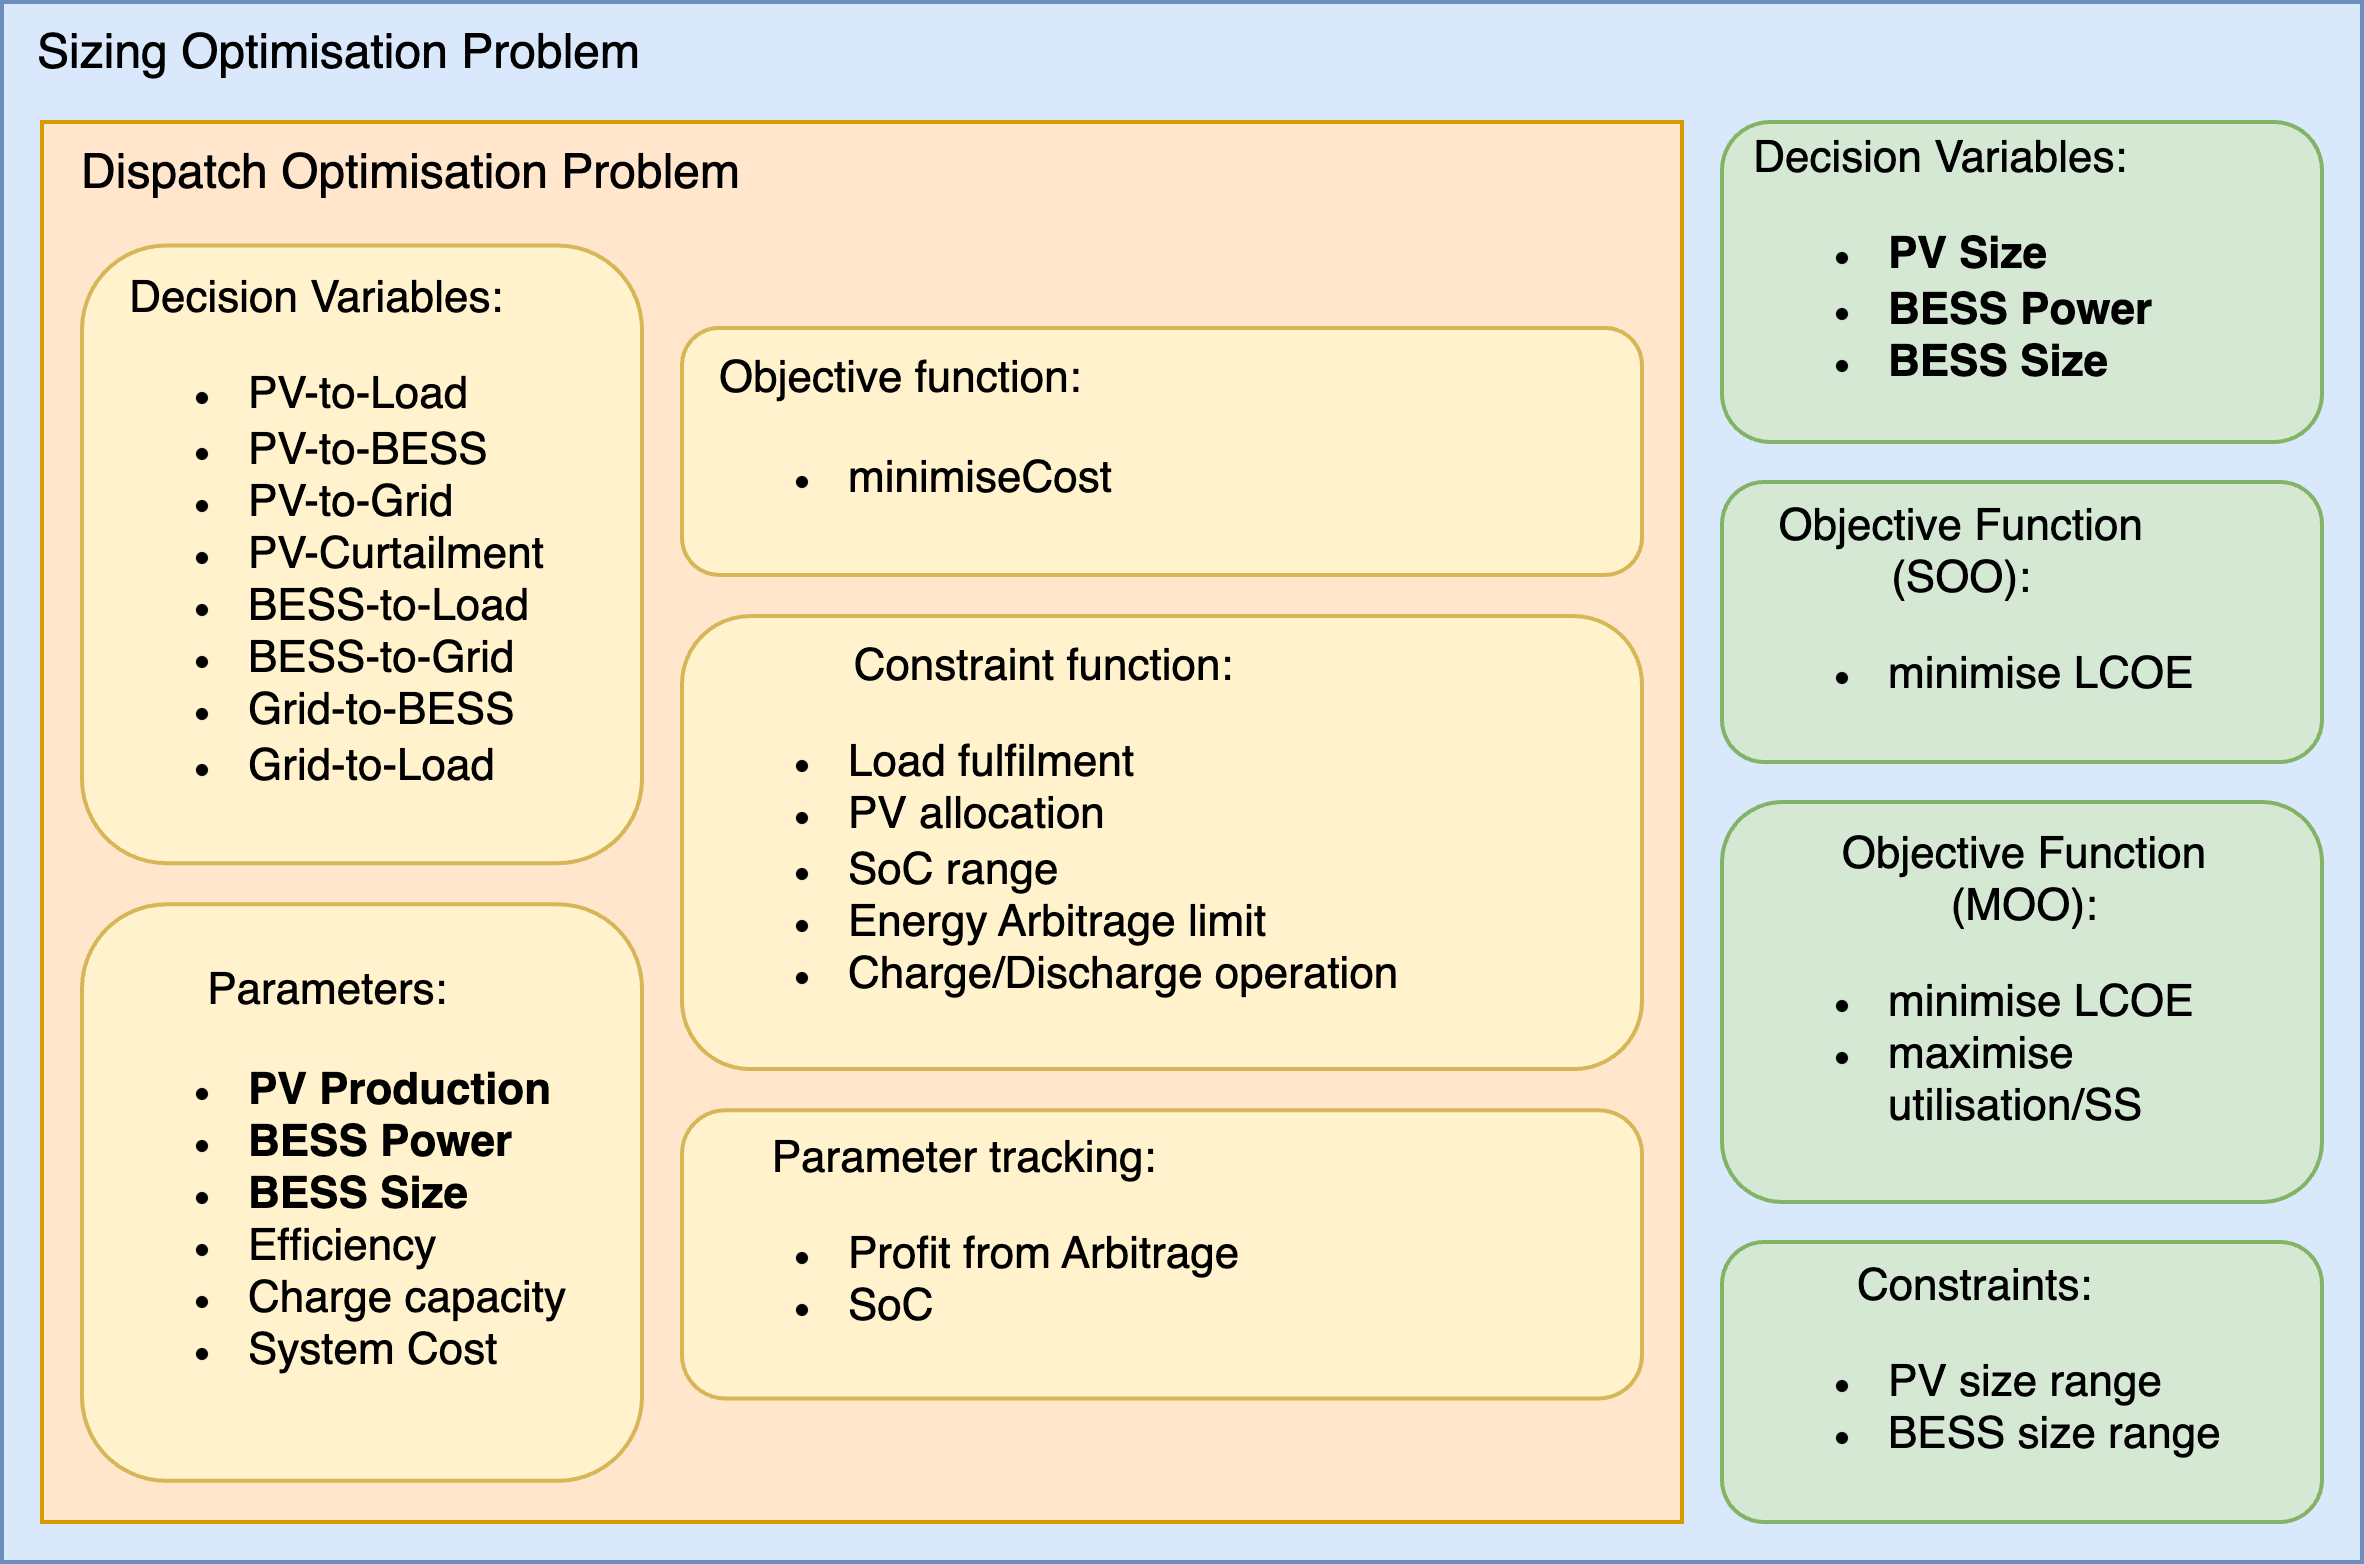

## PostProcessing

In [ ]:
# def calc_lcoe(annual_output, capital_cost, annual_operating_cost, discount_rate, degradation_rate, lifetime):
#     discount_factor_annualised = ( (1 - ( 1/( ( 1 + discount_rate ) **lifetime ) ) ) * ( 1 + discount_rate )) / ( ( 1 + discount_rate ) -1 )
#     degradation_factor_annualised = ( (1 - ( 1/( ( 1 + degradation_rate ) **lifetime ) ) ) * ( 1 + degradation_rate )) / ( ( 1 + degradation_rate ) -1 )
#     result = ( capital_cost + annual_operating_cost * discount_factor_annualised ) / ( annual_output * degradation_factor_annualised )
#     return result


# def get_KPIs(profile, solar_factor, PessCH, EnESS):
#     '''
#     Base params/columns when profile is loaded:
#     'interval_hour'
#     'P_PV_to_Load'
#     'P_PV_to_BESS'
#     'P_PV_curtailment'
#     'P_PV_to_Grid'
#     'P_BESS_to_Load'
#     'P_BESS_to_Grid'
#     'P_Grid_to_Load'
#     'P_Grid_to_BESS'
#     'SoC_BESS'
#     '''
#     price_curve= pd.read_csv(
#         'Data/PriceCurve_SE3_2021.csv',
#         delimiter = ';',
#         usecols = ['Grid_Price']                        #EUR/MWh
#     )
#     co2_curve= pd.read_csv(
#         'Data/production_emissions.csv',
#         delimiter = ',',
#         usecols = ['carbon_intensity_production_avg']   #gCO2/kWh OR kgCO2/MWh
#     )
#     load= (
#         pd.read_csv(
#             'Data/LoadCurve.csv',
#             sep= ';'
#         )
#     ).sum()


#     pv2load=    profile['P_PV_to_Load'].sum()
#     pv2bess=    profile['P_PV_to_BESS'].sum()
#     pv2curtail= profile['P_curtailment'].sum()
#     pv2grid=    profile['P_PV_to_Grid'].sum()
#     bess2load=  profile['P_BESS_to_Load'].sum()
#     bess2grid=  profile['P_BESS_to_Grid'].sum()
#     grid2load=  profile['P_Grid_to_Load'].sum()
#     grid2bess=  profile['P_Grid_to_BESS'].sum()

#     annual_energy = pv2load + bess2load

#     ## Re-check capex equations and make corrections (e.g. add BOS, BOP, EoL)
#     capex= solar_factor * pv_price * 1000 + EnESS * 1000 * bess_price
#     opex= solar_factor * pv_opex * 1000 + EnESS * 1000 * bess_opex
#     capex_co2= solar_factor * pv_co2 * 1000 + EnESS * 1000 * bess_co2
#     opex_co2= solar_factor * pv_opex_co2 * 1000 + EnESS * 1000 * bess_opex_co2

#     lcoe = calc_lcoe(
#         annual_output= annual_energy,
#         capital_cost= capex,
#         annual_operating_cost= opex,
#         discount_rate= discount_rate,
#         degradation_rate= degradation_rate,
#         lifetime= lifetime_bess
#     )
#     lco2 = calc_lcoe(
#         annual_output= annual_energy,
#         capital_cost= capex_co2,
#         annual_operating_cost= opex_co2,
#         discount_rate= discount_rate,
#         degradation_rate= degradation_rate,
#         lifetime= lifetime_bess
#     )
    
#     ## Add profits equation, other factors
#     savings = 0
#     for i in range(8760):
#         savings += ((price_curve.Grid_Price[i] - 0) * (profile.P_PV[i] + profile.ESS_discharge[i]))
    
#     co2avoided = 0
#     for i in range(8760):
#         co2avoided += ((co2_curve.carbon_intensity_production_avg[i] - 12) * (profile.P_PV[i] + profile.ESS_discharge[i]))

#     payback_period = (dataframe.P_PV * params['pv_price'] * 1000 + dataframe.E_BESS * 1000 * params['bess_price']) / (dataframe.savings_EUR - (dataframe.P_PV * params['pv_opex'] * 1000 + dataframe.E_BESS * 1000 * params['bess_opex']))

#     dataframe['offset_period'] = (dataframe.P_PV * params['pv_co2'] * 1000 + dataframe.E_BESS * 1000 * params['bess_co2']) / dataframe.co2avoided_kgCO2
    
#     dataframe['capacity_factor'] = ((dataframe.pv2load + dataframe.bess2load)/(dataframe.P_PV * 8760)) * 100

#     dataframe['pv_load_ratio'] = dataframe.P_PV / 3.0

#     dataframe['bess_load_ratio'] = dataframe.bess_duration / 3.0

#     dataframe['bess_pv_ratio'] = dataframe.bess_duration / dataframe.P_PV
    
#     ## SS = how much of the load was covered by the PV system
#     dataframe['self_sufficiency'] = ((dataframe.pv2load + dataframe.bess2load) / data.Load.sum()) * 100

#     ## SC = 1 - curtailment factor?
#     dataframe['self_consumption'] = ((dataframe.pv2load + dataframe.pv2bess) / (data.solar_PV.sum() * (dataframe.P_PV / 100))) * 100
    
#     dataframe['curtailment_factor'] = ((dataframe.pv_curtailed) / (data.solar_PV.sum() * (dataframe.P_PV / 100))) * 100
    
#     parameters = (
#         solar_factor,
#         PessCH,
#         EnESS,
#         pv2load,
#         pv2bess,
#         pv2curtail,
#         pv2grid,
#         bess2load,
#         bess2grid,
#         grid2load,
#         grid2bess,
#         annual_energy,
#         capex,
#         opex,
#         capex_co2,
#         opex_co2,
#         lcoe,
#         lco2,
#         savings,
#         co2avoided,
#         self_sufficiency
#     )
#     return parameters

In [ ]:
# def replace_value_in_column(df, column_name, old_value, new_value):
#     df[column_name] = df[column_name].replace(old_value, new_value)
#     return df

# def remove_rows_with_specific_value(df, column_name, value):
#     return df[df[column_name] != value]

# def remove_rows_above_specific_value(df, column_name, value):
#     return df[df[column_name] <= value]

# def remove_rows_below_specific_value(df, column_name, value):
#     return df[df[column_name] >= value]

# def get_pareto_front(point, points):
#     return np.any(np.all(points <= point, axis=1)) and np.any(np.all(points > point, axis=1))

In [ ]:
# ## import Dispatchers.PVBESS_dispatch_res as res_dispatcher
# ## import Dispatchers.PVBESS_dispatch_resarbitrage as resarbitrage_dispatcher

# import Dispatchers.test_res_dispatcher as test_res
# import Dispatchers.test_resarbitrage_dispatcher as test_resarbitrage

In [ ]:
# path_excel = os.path.join(os.getcwd(), "Data/TES_example_data.xlsm")
# optimise_for_curves = ['price', 'co2']
# ## P_PV range: 5 to 25
# pv_scaling= [0.05, 0.10, 0.15, 0.20, 0.25]
# ## P_BESS range: 3 - 15
# bess_power= [3, 5, 7, 9, 11, 13, 15]
# ## E_BESS range: (0 - 8) * P_BESS
# bess_capacity= [0, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
# path_excel = os.path.join(os.getcwd(), "Data/TES_example_data.xlsm")
# optimise_for_curves = ['price', 'co2']
# solar = [0.1, 0.2, 0.3, 0.4, 0.5]
# power_list = [1, 2, 3, 4, 5]
# capacity_list = [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#     7,
#     8,
#     9,
#     10]

# cases_ran= []
# X = 48  ## hourly (time) horizon for the dispatch optimiser
# N = 183 ## 386/X
# for type in optimise_for_curves:
#     for capacity in capacity_list:
#         for power in power_list:
#             for solar_factor in solar:
#                 PessCH = power
#                 EnESS = int(power * capacity)

#                 #cases_ran_counter += 1
                
#                 cases_ran.append(
#                     [
#                         f'Solar scale: {solar_factor * 100} MW',
#                         f'BESS Power: {PessCH} MW',
#                         f'BESS Capacity: {EnESS} MWh/{capacity} hr',
#                         f'Optimised for: {type}'
#                     ]
#                 )
                
                
#                 '''
#                 Insert the code to call and run the dispatcher
#                 '''
#                 model = test_res.BatteryModel()
#                 model.import_data(
#                     path_excel,
#                     EnESS,              # EnESS_min
#                     PessCH,             # PessCH_min
#                     solar_factor,       # Solar scaling factor
#                     type                # Optimising for price or CO_2_eq
#                 )

#                 results_only_values = np.zeros((X, 10))
#                 dispatch_profile = np.zeros((1, 10))
#                 #dispatch_profile = pd.DataFrame(columns = ['Hour', 'ESS_discharge', 'P_PV', 'P_charge', 'P_curtailment', 'P_grid', 'SoC'])

#                 results_last_step = np.zeros((10, 1))
#                 results_last_step[-1] = int(EnESS * 0.5)

#                 for i in range(N):
#                     per_case_counter = []
#                     per_case_counter.append(i/(N-1))

#                     model.populate_parameters(i, results_only_values, results_last_step, path_excel, EnESS, PessCH)
#                     model.define_model()
#                     solveStatus = model.solve_model()
#                     results = model.get_results()   # Shows the intermediate 48 hour profile
#                     # print(results)
#                     results_only_values_main = results.to_numpy()
#                     results_only_values = results_only_values_main
#                     # dispatch_profile.loc[len(dispatch_profile)] = results_only_values
#                     dispatch_profile = np.concatenate([dispatch_profile, results_only_values], axis = 0)
#                     #dispatch_profile = pd.merge(dispatch_profile, results_only_values, how= 'right')

#                     results_last_step = results_only_values[-1,:]
#                     model.reset_components()
                
#                 dispatch_profile = pd.DataFrame(data = dispatch_profile)
#                 #dispatch_profile.to_csv(f'Results_W/d_profile_{cases_ran_counter}_{type}_{solar_factor}_{PessCH}_{EnESS}.csv')
#                 dispatch_profile.to_csv(f'Results/Results_New/CaseA/d_profile_{type}_{int(solar_factor * 100)}_{PessCH}_{EnESS}.csv')